This notebook showcases the usage of the Enformer model published in

**"Effective gene expression prediction from sequence by integrating long-range interactions"**

Žiga Avsec, Vikram Agarwal, Daniel Visentin, Joseph R. Ledsam, Agnieszka Grabska-Barwinska, Kyle R. Taylor, Yannis Assael, John Jumper, Pushmeet Kohli, David R. Kelley

### Steps

This notebook demonstrates how to
- Make predictions with Enformer and reproduce Fig. 1d
- Compute contribution scores and reproduce parts of Fig. 2a
- Predict the effect of a genetic variant and reproduce parts of Fig. 3g
- Score multiple variants in a VCF 

## Setup

**If you are using google colab , start kernel with GPU**: Runtime -> Change runtime type -> GPU

In [1]:
import tensorflow as tf
# Make sure the GPU is enabled 
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

In [2]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
# You can ignore the pyYAML error

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.


### Imports

In [3]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/root/data/genome.fa'
clinvar_vcf = '/root/data/clinvar.vcf.gz'

In [5]:
# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


### Download files

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [6]:
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data

--2021-10-30 13:42:59--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  9.43MB/s    in 46s     

2021-10-30 13:43:44 (20.6 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


Download the clinvar file. Reference:

Landrum MJ, Lee JM, Benson M, Brown GR, Chao C, Chitipiralla S, Gu B, Hart J, Hoffman D, Jang W, Karapetyan K, Katz K, Liu C, Maddipatla Z, Malheiro A, McDaniel K, Ovetsky M, Riley G, Zhou G, Holmes JB, Kattman BL, Maglott DR. ClinVar: improving access to variant interpretations and supporting evidence. Nucleic Acids Res . 2018 Jan 4. PubMed PMID: 29165669 .


In [7]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

--2021-10-30 13:44:58--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 165.112.9.228, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45046669 (43M) [application/x-gzip]
Saving to: ‘/root/data/clinvar.vcf.gz’

/root/data/clinvar. 100%[===================>]  42.96M  59.7MB/s    in 0.7s    

2021-10-30 13:44:59 (59.7 MB/s) - ‘/root/data/clinvar.vcf.gz’ saved [45046669/45046669]



## Enformer, EnformerScoreVariantsNormalized, EnformerScoreVariantsPCANormalized

In [8]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism
  
  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [9]:
# @title `variant_centered_sequences`

class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)
    
  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [10]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequenece

In [11]:
model = Enformer(model_path)

In [15]:
# prediction = model.predict_on_batch(wn)["human"][:,:,688]
#wn=genome sequence

# Middle mutation

In [14]:
import copy
import tqdm

mutation_pos = SEQUENCE_LENGTH//2
experiments = []
x = np.eye(4)


"""
change the for loop range to get a better result
"""
for i in tqdm.tqdm(range(2)):
  ### here the avg is over 100 but next two shells is 2 
  # Baseline
  random_genome_sequence = x[np.random.choice(x.shape[0], size=SEQUENCE_LENGTH)][np.newaxis, : , :]
  baseline = model.predict_on_batch(random_genome_sequence)["human"][:,:,688].flatten()

  # Response
  changed_random_genome_sequence = copy.deepcopy(random_genome_sequence)
  changed_random_genome_sequence[0, mutation_pos, :] = np.roll(changed_random_genome_sequence[0, mutation_pos, :], 
                                                                     shift=np.random.randint(1,3))
  output = model.predict_on_batch(changed_random_genome_sequence)["human"][:,:,688].flatten()

  experiments.append(output - baseline)


100%|██████████| 2/2 [01:01<00:00, 30.57s/it]


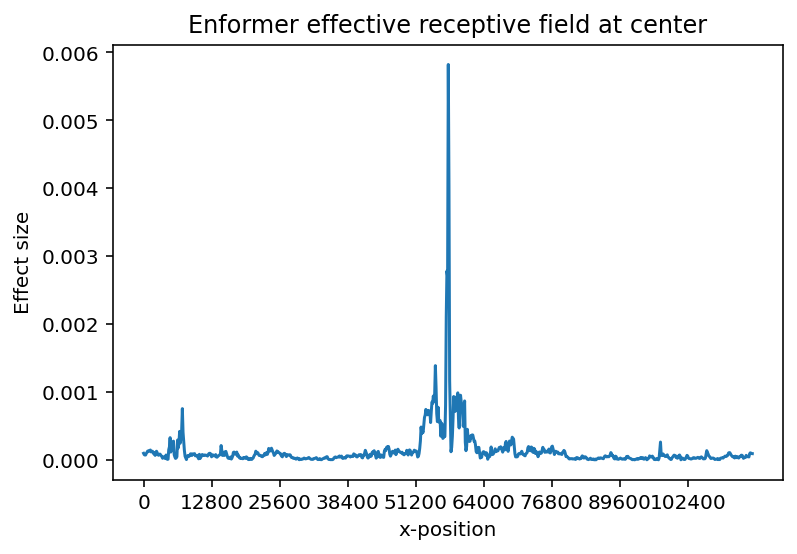

In [16]:
effect_window = np.mean(np.abs(np.array(experiments)), axis=0)
plt.plot(effect_window)
plt.xticks(ticks=np.arange(0, len(experiments[0]), 100), 
           labels=np.arange(0, len(experiments[0])*128, 128*100))
plt.title("Enformer effective receptive field at center")
plt.xlabel("x-position")
plt.ylabel("Effect size");

# Left mutation

In [17]:
import copy
import tqdm

mutation_pos = 98305
experiments = []
x = np.eye(4)

for i in tqdm.tqdm(range(2)):
  # Baseline
  random_genome_sequence = x[np.random.choice(x.shape[0], size=SEQUENCE_LENGTH)][np.newaxis, : , :]
  baseline = model.predict_on_batch(random_genome_sequence)["human"][:,:,688].flatten()

  # Response
  changed_random_genome_sequence = copy.deepcopy(random_genome_sequence)
  changed_random_genome_sequence[0, mutation_pos, :] = np.roll(changed_random_genome_sequence[0, mutation_pos, :], 
                                                                     shift=np.random.randint(1,3))
  output = model.predict_on_batch(changed_random_genome_sequence)["human"][:,:,688].flatten()

  experiments.append(output - baseline)


100%|██████████| 2/2 [00:24<00:00, 12.11s/it]




```
INPUT:  393'000 
OUTPUT:  892 (binned in 128 bp bins) ~ 120'000

MUT:    -   -    *       *
INPUT:  XXXXXXXOOOOOOOOOOOOOOOOOOOOOXXXXXXXXX
OUTPUT:        OOOOOOOOOOOOOOOOOOOOO
```



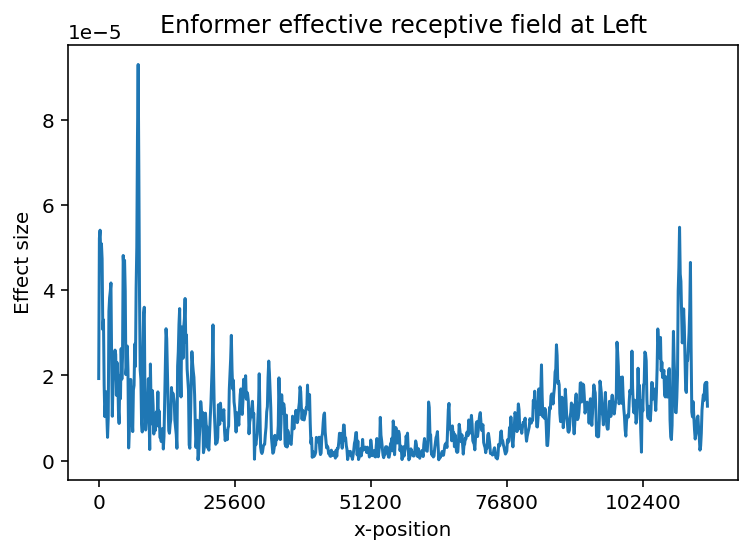

In [18]:
effect_window = np.mean(np.abs(np.array(experiments)), axis=0)
plt.plot(effect_window)
plt.xticks(ticks=np.arange(0, len(experiments[0]), 200), labels=np.arange(0, len(experiments[0])*128, 128*200))
plt.title("Enformer effective receptive field at Left")
plt.xlabel("x-position")
plt.ylabel("Effect size");

# Right Mutation

In [19]:
import copy
import tqdm

mutation_pos = SEQUENCE_LENGTH-98305
experiments = []
x = np.eye(4)

for i in tqdm.tqdm(range(2)):
  # Baseline
  random_genome_sequence = x[np.random.choice(x.shape[0], size=SEQUENCE_LENGTH)][np.newaxis, : , :]
  baseline = model.predict_on_batch(random_genome_sequence)["human"][:,:,688].flatten()

  # Response
  changed_random_genome_sequence = copy.deepcopy(random_genome_sequence)
  changed_random_genome_sequence[0, mutation_pos, :] = np.roll(changed_random_genome_sequence[0, mutation_pos, :], 
                                                                     shift=np.random.randint(1,3))
  output = model.predict_on_batch(changed_random_genome_sequence)["human"][:,:,688].flatten()

  experiments.append(output - baseline)

100%|██████████| 2/2 [00:24<00:00, 12.12s/it]


In [ ]:
SEQUENCE_LENGTH

393216

In [ ]:
experiments[0].shape

(896,)

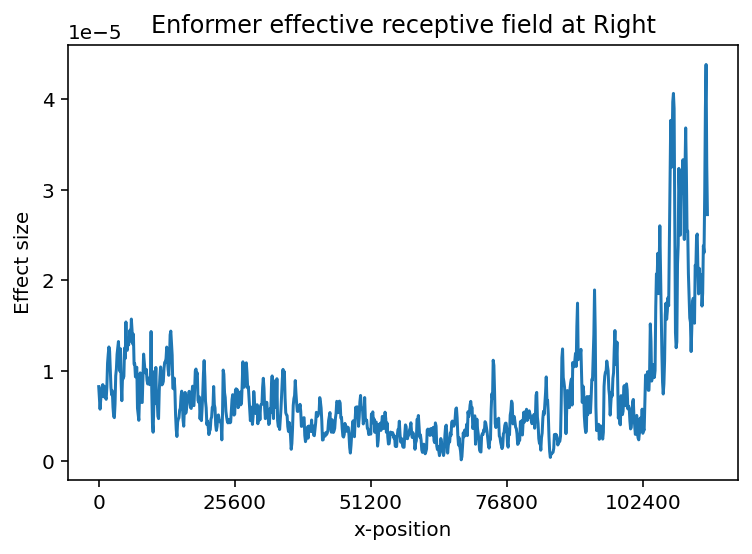

In [ ]:
effect_window = np.mean(np.abs(np.array(experiments)), axis=0)
plt.plot(effect_window)
plt.xticks(ticks=np.arange(0, len(experiments[0]), 200), labels=np.arange(0, len(experiments[0])*128, 128*200))
plt.title("Enformer effective receptive field at Right")
plt.xlabel("x-position")
plt.ylabel("Effect size");

In [ ]:
##########23/92021
### precisely -- 98000
## should have sensitivity everywhere ? 
"""
output: 114,688
each side: 40,960
inp: 196,608
I think this should be the cut-off: 98304
we could remove 98304 on either side - no effect on the model

Enformer cut-off: 98304
8:25
While 98305 is just in the range
8:25
(It's 393'216 / 4 )
8:29
Enformer:

IN:       XXX YYY OOOOO YYY XXX
OUT:              OOOOO
8:30
Y ... model is sensitive to this position.  O ... model outputs prediction for this region. X .... useless
8:30
XXX region size = 98'304
8:31
OOO region size = 114,688
New
8:31
Total length (XXX + YYY + OOOOO + YYY + XXX) = 393216

"""

"\noutput: 114,688\neach side: 40,960\ninp: 196,608\nI think this should be the cut-off: 98304\nwe could remove 98304 on either side - no effect on the model\n\nEnformer cut-off: 98304\n8:25\nWhile 98305 is just in the range\n8:25\n(It's 393'216 / 4 )\n8:29\nEnformer:\n\nIN:       XXX YYY OOOOO YYY XXX\nOUT:              OOOOO\n8:30\nY ... model is sensitive to this position.  O ... model outputs prediction for this region. X .... useless\n8:30\nXXX region size = 98'304\n8:31\nOOO region size = 114,688\nNew\n8:31\nTotal length (XXX + YYY + OOOOO + YYY + XXX) = 393216\n\n"

In [ ]:
prediction = model.predict_on_batch(wn)

In [ ]:
# @title Make predictions for an genomic example interval
target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

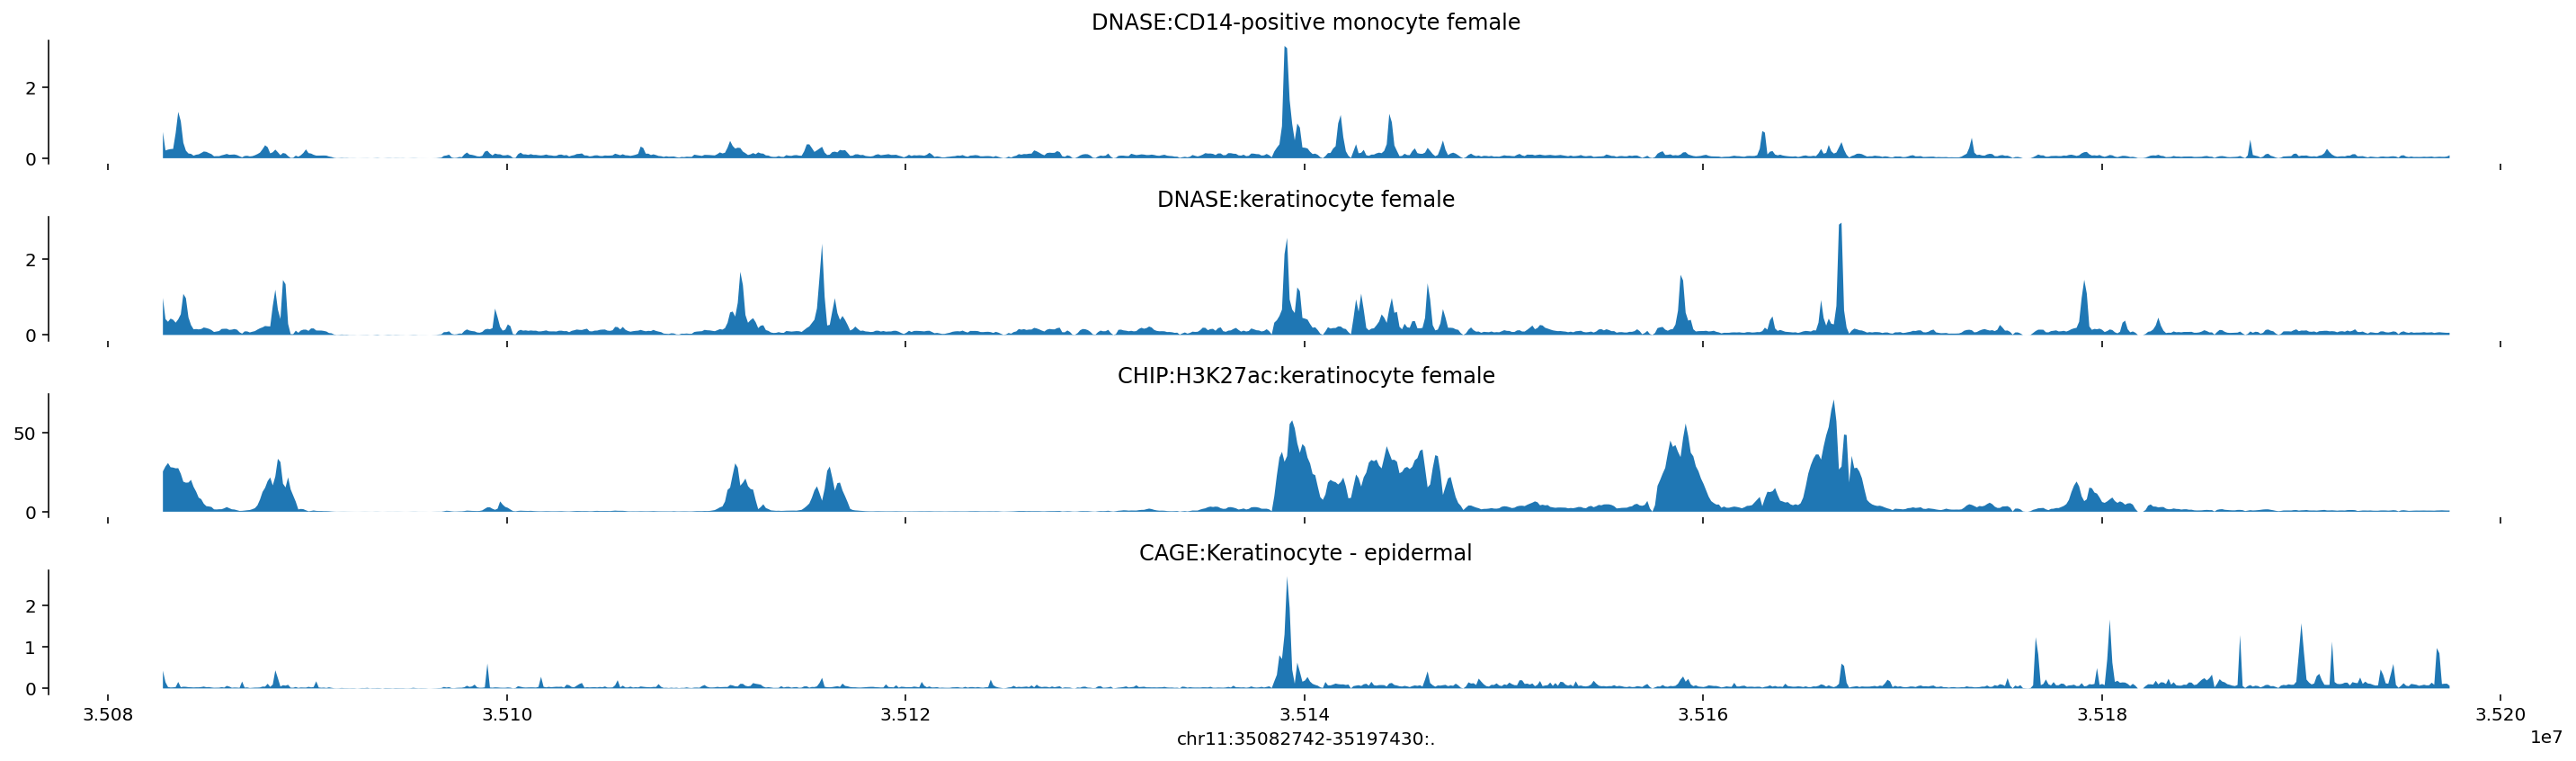

In [ ]:
# @title Plot tracks
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799])}
plot_tracks(tracks, target_interval)

## Contribution scores example

In [ ]:
# @title Compute contribution scores
target_interval = kipoiseq.Interval('chr12', 54_223_589, 54_338_277)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

target_mask = np.zeros_like(predictions)
for idx in [447, 448, 449]:
  target_mask[idx, 4828] = 1
  target_mask[idx, 5111] = 1
# This will take some time since tf.function needs to get compiled.
contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]

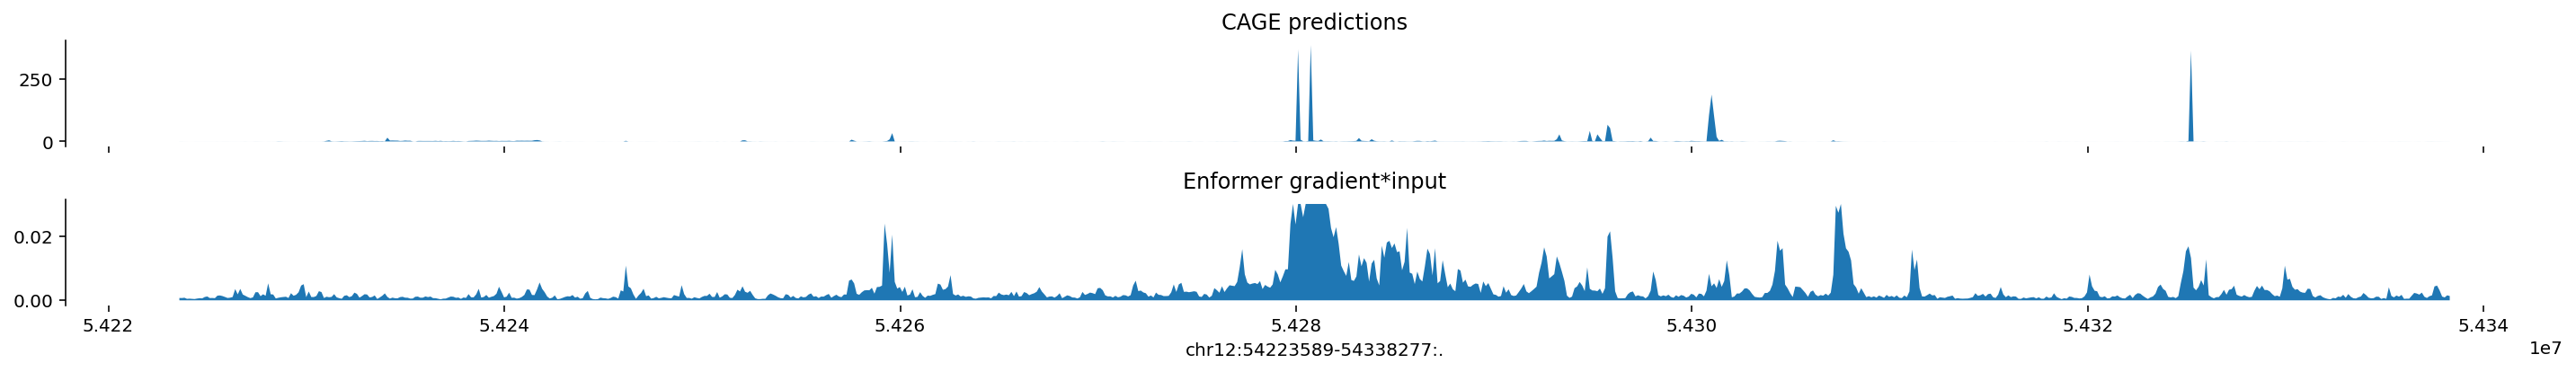

In [ ]:
tracks = {'CAGE predictions': predictions[:, 4828],
          'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
plot_tracks(tracks, target_interval);

## Variant scoring example

In [ ]:
# @title Score the variant
variant = kipoiseq.Variant('chr16', 57025062, 'C', 'T', id='rs11644125')  # @param

# Center the interval at the variant
interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)

# Make predictions for the refernece and alternate allele
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

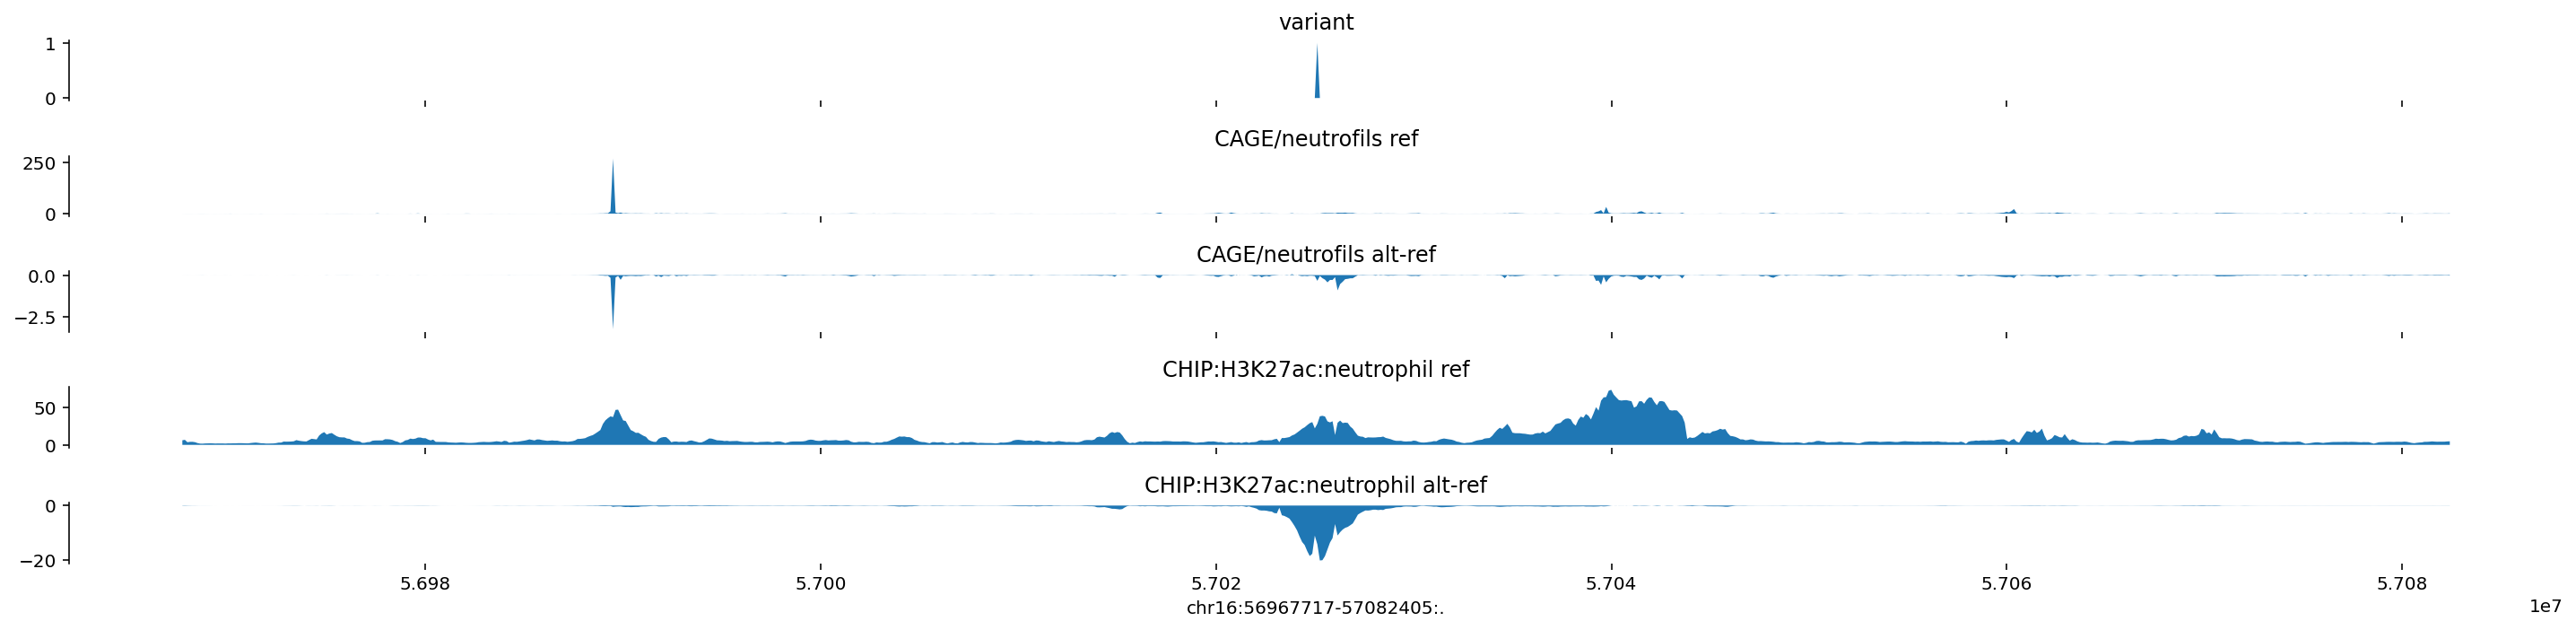

In [ ]:
# @title Visualize some tracks
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE/neutrofils ref': reference_prediction[:, 4767],
          'CAGE/neutrofils alt-ref': alternate_prediction[:, 4767] - reference_prediction[:, 4767],
          'CHIP:H3K27ac:neutrophil ref': reference_prediction[:, 2280],
          'CHIP:H3K27ac:neutrophil alt-ref': alternate_prediction[:, 2280] - reference_prediction[:, 2280],
          }

plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

## Score variants in a VCF file

### Report top 20 PCs

In [ ]:
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at yo

In [ ]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,925952,1019397,G,A,13.865371,9.379375,1.322473,7.198019,11.926774,-4.407538,-5.878580,-10.701156,-3.140507,2.994015,4.716916,1.098637,2.569388,13.693736,8.564518,9.383035,-2.159512,-9.733231,7.727090,-0.669298
1,chr1,930188,846933,G,A,-61.468933,-5.653942,-2.758731,6.289482,1.844845,3.446712,6.052454,0.632046,2.584915,1.117951,1.942497,-6.513691,-4.948788,-1.172066,-2.903700,0.482835,2.896945,1.757883,3.686084,-6.673547
2,chr1,930200,1043045,G,A,-61.995975,-10.007704,-0.312641,10.605079,-5.349404,-2.555728,7.008485,9.793589,-14.216670,4.411201,0.295830,-4.968991,-10.770261,-1.512434,0.186349,7.461446,5.153117,4.041459,0.512155,-2.865725
3,chr1,930203,972363,C,T,21.486368,-9.248886,3.684767,9.606424,0.538447,5.264496,1.418155,-14.005326,12.898662,9.391730,-5.201692,-3.091272,1.975370,-5.240757,-14.367105,-7.802942,0.138479,12.087408,-5.559704,9.171222
4,chr1,930222,998906,GAACTC,TTCTTCTG,13.672197,181.645172,-302.586548,184.414001,146.373199,284.204163,-108.902489,100.794731,-205.568008,302.769409,203.416458,111.947685,-61.380695,222.271515,152.539993,114.129166,-26.604349,-68.656372,-36.595196,38.175354


### Report all 5,313 features (z-score normalized)

In [ ]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
# Score the first 5 variants from ClinVar
# All Scores
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants_all.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'{i}_{name[:20]}': score for i, (name, score) in enumerate(zip(df_targets.description, variant_scores))}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,DNASE:cerebellum mal,DNASE:frontal cortex,DNASE:chorion,DNASE:Ishikawa treat,DNASE:GM03348,DNASE:GM03348 geneti,DNASE:AG08395,DNASE:AG08396,DNASE:AG20443,DNASE:H54,DNASE:GM10248,DNASE:GM12878,DNASE:GM12891,DNASE:GM12892,DNASE:GM18507,DNASE:GM19238,DNASE:GM19239,DNASE:GM19240,DNASE:H1-hESC,DNASE:H7-hESC,DNASE:H9,DNASE:heart male adu,DNASE:HEK293T,DNASE:HeLa-S3 treate,DNASE:HeLa-S3,DNASE:hepatocyte,DNASE:HepG2,DNASE:HTR-8/SVneo,DNASE:endothelial ce,DNASE:CWRU1 male,DNASE:iPS-NIHi11 mal,DNASE:iPS-NIHi7 fema,DNASE:K562 treated w,DNASE:K562 G2 phase,DNASE:K562 G1 phase,...,CAGE:CD14+CD16- Mono,CAGE:achilles tendon,CAGE:cerebrospinal f,CAGE:cruciate ligame,CAGE:eye - vitreous,CAGE:eye - muscle su,CAGE:eye - muscle la,CAGE:eye - muscle me,CAGE:eye - muscle in,CAGE:Fingernail (inc,"CAGE:optic nerve,","CAGE:Skin - palm,",CAGE:tongue epidermi,"CAGE:Urethra,",CAGE:CD14+ monocytes,CAGE:Hep-2 cells tre,CAGE:Hep-2 cells moc,CAGE:immature langer,CAGE:migratory lange,CAGE:CD34 cells diff,CAGE:amygdala - adul,CAGE:thalamus - adul,CAGE:hippocampus - a,CAGE:parietal lobe -,CAGE:cerebellum - ad,CAGE:pineal gland -,CAGE:spinal cord - a,CAGE:Olfactory epith,CAGE:gamma delta pos,"CAGE:Mast cell, expa","CAGE:adipose,","CAGE:cerebellum, new","CAGE:spinal cord, ne","CAGE:amygdala, newbo","CAGE:hippocampus, ne","CAGE:putamen, newbor","CAGE:thalamus, newbo",CAGE:thymic carcinom,CAGE:Smooth muscle c,CAGE:parietal cortex
0,chr1,925952,1019397,G,A,-3.953313,-2.132398,-1.133056,-0.018265,-7.324341,-5.928950,-2.696301,-2.234811,-1.869620,16.743450,2.218565,3.167206,1.084149,0.671318,6.513158,0.971147,6.255165,5.352125,1.729454,-3.350782,1.896389,-1.563089,-2.268677,11.647644,14.272476,-7.074303,1.850793,5.803924,0.381484,-0.443644,-0.299062,-0.139204,-8.861604,-8.072408,-6.212577,...,-0.046439,4.083508,3.535412,11.717014,-5.239547,1.081644,2.213174,0.853902,-0.216257,2.654844,0.402727,1.567667,3.049335,1.010953,-0.800231,157.583069,172.648773,0.576450,5.026437,0.464598,2.133233,1.689052,2.324542,1.849092,-1.319847,-25.130344,2.456997,11.093707,-4.529293,5.072914,-6.317924,-2.482907,1.591787,-5.362659,0.643638,-1.936050,2.499822,12.372701,23.365688,2.915666
1,chr1,930188,846933,G,A,-1.791559,-15.679683,-22.533566,0.523771,-3.826311,-3.219894,-2.668196,-9.468966,-3.158970,-7.704255,-3.150757,-0.523286,-11.126574,-11.116987,-3.674609,-8.464477,-11.757355,-8.595486,-0.536293,0.227047,-0.779173,-15.736004,0.879350,-6.572251,-4.200795,-8.630462,-0.465244,-3.442806,-0.311721,-4.801476,-5.145035,-1.415882,0.362791,-1.997213,-2.307346,...,-33.052082,-2.994223,-8.416894,-5.190420,-4.534584,-5.453042,-3.034095,-7.163062,-2.291493,-8.985706,-4.789318,-4.794244,-1.449592,-1.989321,-22.916094,-35.752350,-35.275730,-13.375345,-28.358622,-31.596754,-11.371334,-9.254264,-9.006978,-9.230368,-3.783889,-0.283448,-12.094806,-59.170837,-66.303123,-34.475914,-21.272675,-4.328580,-16.075752,-6.281566,-10.389462,-6.422119,-9.181828,-14.224935,-46.487968,-11.499000
2,chr1,930200,1043045,G,A,-0.526763,-14.688834,-17.484657,2.908407,2.734465,3.514852,0.294236,-4.154023,1.062205,-7.452735,-2.387097,-0.988034,-7.148329,-7.479169,-3.070057,-9.537191,-12.243765,-10.340226,0.070186,0.338647,-0.706960,-13.103579,3.004640,-8.224607,-7.412826,-9.011602,0.814177,-2.572933,0.154302,-4.661432,-3.152854,-1.105172,-2.336678,-4.403462,-4.830977,...,-26.200890,-4.082983,-11.688838,-5.358507,-5.728800,-6.592316,-5.169149,-8.596480,-3.361437,-6.800953,-4.874091,-4.676669,-2.054912,-2.659639,-19.059345,-86.237938,-90.280151,-13.633442,-32.443680,-19.412699,-7.266642,-7.957299,-6.725488,-6.803071,-6.814243,1.440345,-8.739142,-70.331505,-39.735146,-31.107134,-18.125492,-3.016214,-8.161813,-12.665734,-9.362435,-5.167178,-3.976753,-12.334543,-38.066742,-8.078856
3,chr1,930203,972363,C,T,3.887291,-0.802319,-1.669034,4.747784,1.695362,2.217486,-0.282765,-1.139245,0.368520,-3.772724,3.466754,1.096701,2.536208,5.108255,1.874467,3.965143,1.232345,3.818713,0.651470,2.554193,0.991104,1.639103,